# Midterm 1, Spring 2023: Mining for Friends #


<a href="pmt1-28.html" target="_blank">Solution</a>  
_Version history_
* 1.2 Ex8: Rephrased note
* 1.1 Ex3: Edited output requirements
* 1.0 Initial release

*All of the header information is important. Please read it.*

**Topics, number of exercises:** This problem builds on your knowledge of basic Python data structures, nested data structures, and string manipulation. It has **10** exercises, numbered 0 to **9**. There are **18** available points. However, to earn 100% the threshold is **13** points. _(Therefore, once you hit **13** points, you can stop. There is no extra credit for exceeding this threshold.)_

**Exercise ordering:** Each exercise builds logically on previous exercises, but you may solve them in any order. That is, if you can't solve an exercise, you can still move on and try the next one. Use this design to your advantage, as the exercises are **not** necessarily ordered in terms of difficulty. Higher point values generally indicate more difficult exercises. 

**Demo cells:** Code cells starting with the comment `### define demo inputs` load results from prior exercises applied to the entire data set and use those to build demo inputs. These cells must be run for subsequent demos to work properly, but they do not affect the test cells. The data loaded in these cells may be rather large (at least in terms of human readability). You are free to print or otherwise use Python to explore them, but we did not print them in the starter code.

**Debugging you code:** Right before each exercise test cell, there is a block of text explaining the variables available to you for debugging. You may use these to test your code and can print/display them as needed (careful when printing large objects, you may want to print the head or chunks of rows at a time).

**Exercise point breakdown:**

- Exercise 0: **1** point
- Exercise 1: **1** point
- Exercise 2: **3** points
- Exercise 3: **2** points
- Exercise 4: **2** points
- Exercise 5: **1** point
- Exercise 6: **1** point
- Exercise 7: **2** points
- Exercise 8: **2** points
- Exercise 9: **3** points

**Final reminders:** 

- Submit after completing **every exercise**
- Review the generated grade report after you submit to see what errors were returned
- Stay calm, skip problems as needed, and take short breaks as needed

# Background: Mining for Friends #

In this notebook, you will analyze social media data from Twitter and FourSquare. Your ultimate goal will be to help people find others with common interests.

The (anonymized) data consists of the following:

- A collection of places, or _points of interest_ (POIs), like restaurants, movie theaters, post offices, museums, and so on.
- A database of cities.
- A collection of _check-ins_, that is, the places that a specific person has visited.
- Existing _connections_, that is, "who follows whom" type relationships.

We will analyze this data and then, by the very last exercise, create a function that can, for a given person, recommend other people they might be compatible with based on their affinity for the same places.

Start by running the next cell, which will set up some of the code and data you'll need later.

In [1]:
### Global Imports
###
### AUTOGRADER TEST - DO NOT REMOVE
###

# Some functionality needed by the notebook and demo cells:
from pprint import pprint, pformat
import math

def status_msg(s, time=None):
    from datetime import datetime
    if time is None:
        time = datetime.now()
    print(f"[{time}] {s}")    

def load_json(filename):
    from json import load
    with open(filename, "rt") as fp:
        return load(fp)
    return None

def save_json(filename, obj):
    from json import dump
    with open(filename, "w") as fp:
        dump(obj, fp, indent=2)

def load_pickle(filename):
    from pickle import load
    with open(filename, "rb") as fp:
        return load(fp)
    return None

def save_pickle(filename, obj):
    from pickle import dump
    with open(filename, "wb") as fp:
        dump(obj, fp)

def choose_ext(s, ext_map):
    for ext in ext_map:
        if s[-(len(ext)+1):] == f".{ext}":
            return ext_map[ext]
    return None

def load_database(basename, tag=None, sample=None, pathname="resource/asnlib/publicdata/"):
    filename = pathname + basename
    status_msg(f"Loading {tag+' ' if tag is not None else ''}[{filename}] ...")
    loader = choose_ext(basename, {'pickle': load_pickle, 'json': load_json})
    assert loader is not None, "*** Unrecognized file extension. ***"
    database = loader(filename)
    status_msg("... done!")
    print(f"\nThis data has {len(database):,} entries.")
    if sample is not None and isinstance(database, dict):
        print("\nHere is a sample:\n")
        pprint({key: database[key] for key in sample})
    return database

def save_database(database, basename, tag=None, sample=None, pathname="resource/asnlib/publicdata/"):
    if sample is not None and isinstance(database, dict):
        database = {key: database[key] for key in sample}
    print(f"This data has {len(database):,} entries.")
    filename = pathname + basename
    status_msg(f"\nSaving {tag+' ' if tag is not None else ''}[{filename}] ...")
    saver = choose_ext(basename, {'pickle': save_pickle, 'json': save_json})
    assert saver is not None, "*** Unrecognized file extension. ***"
    saver(filename, database)
    status_msg("... done!")

def sample_dict(d, k=1):
    """Extract a sample of at most `k` key-value pairs from the dictionary `d`."""
    assert k >= 0, f"*** The number of samples must be nonnegative (k={k}). ***"
    from random import sample
    keys = sample(d.keys(), min(k, len(list(d.keys()))))
    return {k: d[k] for k in keys}

def sample_safely(x, k):
    """Returns a set of at most `k` uniform-random samples from `x`."""
    from random import sample
    return set(sample(x, min(k, len(x))))

def subset_dict(d, ks):
    """Returns a subset of the dictionary `d` for the keys `ks`."""
    return {k: v for k, v in d.items() if k in ks}

def enum_map(x):
    map_dict = {e: k for k, e in enumerate(x)}
    return lambda i: map_dict[i]

def remap_dict(d, map_key=lambda k: k, map_val=lambda k: k):
    """Relabel the key-value pairs of a dictionary."""
    assert len(set(map_key(k) for k in d.keys())) == len(d.keys()), '*** `map_key` is not one to one ***'
#    assert len(set(map_val(k) for k in d.values())) == len(d.values()), '*** `map_val` is not one to one ***'
    return {map_key(k): map_val(v) for k, v in d.items()}

def remap_set(s, map_fun=lambda e: e):
    """Relabel the elements of a set."""
    s_new = {map_fun(e) for e in s}
    assert len(s_new) == len(s), "*** `map_fun` is not one to one ***"
    return s_new

# Part A: Points-of-interest and cities #

The first part of the dataset consists of **points-of-interest** or **POIs**. A POI is a place that a person can visit.

Run this code cell to load the dataset of POIs.

In [2]:
pois = load_database('pois.pickle',
                     tag="points-of-interest (POIs)",
                     sample=['4f4f5309771648ea92a4bc21', '4d52b314d7eaa1434b90810f', '4d24cfc22ac6f04d13473845'])

[2024-11-07 02:11:10.125149] Loading points-of-interest (POIs) [resource/asnlib/publicdata/pois.pickle] ...
[2024-11-07 02:11:10.983673] ... done!

This data has 643,853 entries.

Here is a sample:

{'4d24cfc22ac6f04d13473845': {'country_code': 'BR',
                              'lat': -22.733382,
                              'long': -45.12249,
                              'type': 'University'},
 '4d52b314d7eaa1434b90810f': {'country_code': 'TR',
                              'lat': 41.022555,
                              'long': 29.117048,
                              'type': 'Automotive Shop'},
 '4f4f5309771648ea92a4bc21': {'country_code': 'TR',
                              'lat': 36.972507,
                              'long': 35.046473,
                              'type': 'Turkish Restaurant'}}


There are over half-a-million POIs. Each one is stored as a key-value pair where
- the key is the **POI's ID**; and
- the value holds the **POI's attributes**, stored as another Python dictionary.

In the sample above, there are three POIs, each one with four attributes.
- **`'country_code'`**: A two-letter country code indicating in which country the POI is located. In this example, one is in Brazil (`'BR'`) and two in Turkey (`'TR'`).
- **`'lat'` and `'long'`**: The latitude and longitude coordinates of the POI.
- **`'type'`**: The type of POI. We see three types in this example: a `'University'`, a `'Automotive Shop'`, and a `'Turkish Restaurant'`.

## Exercise 0 (**1** point): `find_food_and_drink_types` ##

To practice inspecting the POIs, suppose we want to find types of POIs that are associated with restaurants, bars, and the like. Implement the function,
```python
def find_food_and_drink_types(pois):
    ...
```
to accomplish this task.

**Inputs:** A collection of POIs as shown above, given as a Python dictionary of dictionaries.

**Task:** For each POI type, which is a string, split the string into "words" using whitespace as a delimiter.

Compare each word to the target list, below. Consider the word a "match" if it is exactly the same except for case. (So `'Food'` and `'FOOD'` match `'food'`, but `'foods'` and `'food'` do not match.)

The target words are:
```
'bar', 'bars', 'beer', 'brewery', 'cafe', 'cafes', 'coffee',
'cocktail', 'cocktails', 'drink', 'drinks', 'food',
'restaurant', 'restaurants', 'sake', 'tea', 'wine',
'whisky', 'whiskey'
```

**Outputs:** Return a Python set containing types whose words matched the target list. The case of the returned types should match the originals _exactly_, including case. (See the demo.)

In [3]:
# Demo input:
demo_pois_ex0 = {'4c0e251bb1b676b0f788e186': {
                     'country_code': 'AT',
                     'lat': 48.257386,
                     'long': 16.400122,
                     'type': 'Fast Food Restaurant'},
                 '4c247550b012b713167d0893': {
                     'country_code': 'HR',
                     'lat': 45.347616,
                     'long': 14.300922,
                     'type': 'Pool'},                     
                 '4fa3c7ade4b0f90206220bbf': {
                     'country_code': 'KR',
                     'lat': 37.545866,
                     'long': 127.122266,
                     'type': 'Bike Shop'}}

<!-- Expected demo output text block -->
If `demo_pois_ex0` (above) is the input, then `find_food_and_drink_types(demo_pois_ex0)` should produce:
```
{'Fast Food Restaurant'}
```
<!-- Include any shout outs here -->

In [4]:
### Exercise 0 solution
def find_food_and_drink_types(pois):
    ###
    targetWords = {'bar', 'bars', 'beer', 'brewery', 'cafe', 'cafes', 'coffee',
    'cocktail', 'cocktails', 'drink', 'drinks', 'food',
    'restaurant', 'restaurants', 'sake', 'tea', 'wine',
    'whisky', 'whiskey'}
    finalSet = set()
    
    for key in pois:
        splitted = pois[key]['type'].split(' ')
        for i in splitted:
            
            for target in targetWords:
                if i.lower() == target.lower():
                    finalSet.add(pois[key]['type'])
    return finalSet
    ###
    
### demo function call
find_food_and_drink_types(demo_pois_ex0)

{'Fast Food Restaurant'}

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 0. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [5]:
### test_cell_ex0
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_0', 
    'func': find_food_and_drink_types, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'pois':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'set',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME: Food and drink types:** If you had a correct solution, you could use it to determine the food and drink types. We have precomputed this list for you, and here are the results. **Run this cell whether or not you completed Exercise 0.**

In [6]:
food_and_drink_types = load_database('food_and_drink_types.pickle')
print(f"\nThere are {len(food_and_drink_types):,} types that match the food and drink keywords. They are:")
print(food_and_drink_types)

[2024-11-07 02:11:11.866530] Loading [resource/asnlib/publicdata/food_and_drink_types.pickle] ...
[2024-11-07 02:11:11.875079] ... done!

This data has 81 entries.

There are 81 types that match the food and drink keywords. They are:
{'Filipino Restaurant', 'Dive Bar', 'Sports Bar', 'Peruvian Restaurant', 'Brazilian Restaurant', 'Airport Food Court', 'Health Food Store', 'Mediterranean Restaurant', 'Mongolian Restaurant', 'Wine Shop', 'Tea Room', 'Gluten-free Restaurant', 'Gaming Cafe', 'Scandinavian Restaurant', 'Dumpling Restaurant', 'Greek Restaurant', 'Ethiopian Restaurant', 'Hookah Bar', 'Turkish Restaurant', 'Restaurant', 'Asian Restaurant', 'Southern / Soul Food Restaurant', 'Latin American Restaurant', 'Molecular Gastronomy Restaurant', 'Beer Garden', 'Arepa Restaurant', 'Vegetarian / Vegan Restaurant', 'Cuban Restaurant', 'Seafood Restaurant', 'Portuguese Restaurant', 'Swiss Restaurant', 'Eastern European Restaurant', 'Mexican Restaurant', 'Malaysian Restaurant', 'Argentinian 

# Part B: Cities #

A second component of the dataset is a collection of **city records**. Run the following cell to load it.

In [7]:
cities = load_database('cities.pickle',
                       tag="cities",
                       sample = ["Beijing, China", "Hartford, United States", "Stockholm, Sweden"])

[2024-11-07 02:11:11.948509] Loading cities [resource/asnlib/publicdata/cities.pickle] ...
[2024-11-07 02:11:11.958289] ... done!

This data has 415 entries.

Here is a sample:

{'Beijing, China': {'country_code': 'CN',
                    'lat': 39.906189,
                    'long': 116.388037,
                    'type': 'National and provincial capital'},
 'Hartford, United States': {'country_code': 'US',
                             'lat': 41.76,
                             'long': -72.702999,
                             'type': 'Provincial capital'},
 'Stockholm, Sweden': {'country_code': 'SE',
                       'lat': 59.331168,
                       'long': 17.991451,
                       'type': 'National and provincial capital'}}


Each city record is a key-value pair. The key is the **city name**, and the value is a dictionary of **city attributes**. The attributes are a two-letter country code, the latitude and longitude coordinates of the city center, and the type of city.

In this example, there are three cities: `'Beijing, China'`, `'Hartford, United States'`, and `'Stockholm, Sweden'`.

**Important!** Both the POIs and the cities are dictionaries of dictionaries, where in both cases the _outer_ dictionary's key-value pairs define a record, and the inner dictionaries have the keys, `'country_code'`, `'lat'`, `'long'`, and `'type'`.

## Exercise 1 (**1** point): `get_common_ccs` ##

Suppose we wish to determine which countries exist in **both** the POIs data **and** the cities data. Implement the function,
```python
def get_common_ccs(pois, cities):
    ...
```
to complete this task.

**Inputs:**
- `pois`: POIs, stored in a Python dictionary of dictionaries, mapping POI IDs keys to attribute values (like earlier examples)
- `cities`: City records, stored in a Python dictionary of dictionaries, mapping city names to attribute values (like earlier examples)

You may assume that the inner dictionaries have the same four keys: `'country_code'`, `'lat'`, `'long'`, and `'type'`.

**Task:** Identify all country codes that exist in `pois` and in `cities`.

**Outputs:** Return a new **Python set** consisting of the common country codes.

In [8]:
### DEMO INPUTS ###
demo_pois_ex1 = \
    {'abc': {'country_code': 'US', 'lat': -5.2, 'long': 2.0, 'type': 'Restaurant'},
     'def': {'country_code': 'US', 'lat': -2.3, 'long': 6.8, 'type': 'Golf Course'},
     'ghi': {'country_code': 'PL', 'lat': 1.0, 'long': 6.5, 'type': 'Apartment'},
     'jkl': {'country_code': 'VN', 'lat': 11.0, 'long': 1.5, 'type': 'Post Office'}}

demo_cities_ex1 = \
    {'Seattle, United States': {'country_code': 'US', 'lat': -5.0, 'long': 3.0, 'type': 'Other'},
     'Richmond, United States': {'country_code': 'US', 'lat': -2.0, 'long': 7.0, 'type': 'Other'},
     'Hanoi, Vietnam': {'country_code': 'VN', 'lat': 10.0, 'long': 2.0, 'type': 'National and provincial capital'},
     'Curitiba, Brazil': {'country_code': 'BR', 'lat': 0.0, 'long': 6.0, 'type': 'Provincial capital'}}

<!-- Expected demo output text block -->
When a correct implementation runs on the demo inputs, it should return
```
{'US', 'VN'}
```
<!-- Include any shout outs here -->
The POI `'PL'` does **not** appear in the output since it exists in `pois` but **not** in `cities`.

In [9]:
### Exercise 1 solution
def get_common_ccs(pois, cities):
    ###
    set1 = set()
    set2 = set()
    
    for code in pois:
        set1.add(pois[code]['country_code'])

    for code in cities:
        set2.add(cities[code]['country_code'])
    
    finalSet = set1.intersection(set2)
    
    return finalSet
    ###

### demo function call
get_common_ccs(demo_pois_ex1, demo_cities_ex1)

{'US', 'VN'}

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 1. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [10]:
### test_cell_ex1
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_1', 
    'func': get_common_ccs, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'pois':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
        'cities':{
            'dtype':'dict',
            'check_modified':True,
        },
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'set',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## Exercise 2 (**3** points): `proximity_join` ##

POI records only have lat-long coordinates. To make their locations more user-friendly, let's associate each POI with its closest city in the same country.

Implement the function,
```python
def proxmity_join(pois, cities):
    ...
```
to help accomplish this task, following the requirements below.

**Inputs:**

- `pois`: POIs, stored in a Python dictionary of dictionaries, mapping POI IDs keys to attribute values (like Exercise 1)
- `cities`: City records, stored in a Python dictionary of dictionaries, mapping city names to attribute values (like Exercise 1)

You may assume that the inner dictionaries of both have the same four keys: `'country_code'`, `'lat'`, `'long'`, and `'type'`.

**Task:** For each POI record, determine which city is _closest_ to it. The closest city must be in the same country (the `'country_code'` values must match).

To measure distance, use the _squared Euclidean distance_. That is, if a POI record has the lat-long coordinates $(h_p, v_p)$, and a city record has the lat-long coordinates $(h_c, v_c)$, then their squared Euclidean distance is

$$(h_p - h_c)^2 + (v_p - v_c)^2.$$

**Outputs:** Your function should return a **new Python dictionary of dictionaries**. The outer dictionary's keys should be the same POI IDs. The inner dictionary should have exactly two keys: `'type'`, which is the **POI type** (not the _city type_), and `'city'`, which is the name of the closest city. See the demo below.

**Notes and hints:**
1. Recall that the IEEE floating-point standard defines a special value that corresponds with infinity. This value is available in Python as `math.inf`, and it may be a helpful initializer as you search for the closest city to a given POI.
2. We have provided a function, `dd_distance_squared`, that will compute the squared Euclidean distance given the attributes of a POI and the attributes of a city.

In [11]:
### DEMO INPUTS ###
demo_pois_ex2 = \
    {'abc': {'country_code': 'US', 'lat': -5.2, 'long': 2.0, 'type': 'Restaurant'},
     'def': {'country_code': 'US', 'lat': -2.3, 'long': 6.8, 'type': 'Golf Course'},
     'ghi': {'country_code': 'PL', 'lat': 1.0, 'long': 6.5, 'type': 'Apartment'},
     'jkl': {'country_code': 'VN', 'lat': 11.0, 'long': 1.5, 'type': 'Post Office'}}

demo_cities_ex2 = \
    {'Seattle, United States': {'country_code': 'US', 'lat': -5.0, 'long': 3.0, 'type': 'Other'},
     'Richmond, United States': {'country_code': 'US', 'lat': -2.0, 'long': 7.0, 'type': 'Other'},
     'Hanoi, Vietnam': {'country_code': 'VN', 'lat': 10.0, 'long': 2.0, 'type': 'National and provincial capital'},
     'Curitiba, Brazil': {'country_code': 'BR', 'lat': 0.0, 'long': 6.0, 'type': 'Provincial capital'}}

<!-- Expected demo output text block -->
The demo included in the solution cell below should display the following output:
```
{'abc': {'type': 'Restaurant', 'city': 'Seattle, United States'},
 'def': {'type': 'Golf Course', 'city': 'Richmond, United States'},
 'jkl': {'type': 'Post Office', 'city': 'Hanoi, Vietnam'}}
 ```
<!-- Include any shout outs here -->

Observe that the POI `'ghi'` does **not** appear in the output. That's because its country code, `'PL'`, does not match any country code of any city.

In [12]:
### Exercise 2 solution
from collections import defaultdict
def proximity_join(pois, cities):
    ###
#     print(pois)
#     print("------------------------------------------------------------------")
#     print(cities)
    finalDict = defaultdict(dict)
    trueFinalDict = defaultdict(dict)
    
    for key in pois:
#         finalDict[key]
#         finalDict[key]['type'] = pois[key]['type']
        for cityKey in cities:
            if pois[key]['country_code'] == cities[cityKey]['country_code'] and len(finalDict[key].keys())==3:
                if dd_distance_squared(pois[key], cities[cityKey]) < finalDict[key]['SS Score']:
                    finalDict[key]
                    SS = dd_distance_squared(pois[key], cities[cityKey])
                    finalDict[key]['type'] = pois[key]['type']
                    finalDict[key]['city'] = cityKey
                    finalDict[key]['SS Score'] = SS
                    
            elif pois[key]['country_code'] == cities[cityKey]['country_code']:
                finalDict[key]
                SS = dd_distance_squared(pois[key], cities[cityKey])
                finalDict[key]['type'] = pois[key]['type']
                finalDict[key]['city'] = cityKey
                finalDict[key]['SS Score'] = SS
    
    for key in finalDict:
        trueFinalDict[key]['type'] = finalDict[key]['type']
        trueFinalDict[key]['city'] = finalDict[key]['city']
        
    return trueFinalDict
    ###
    
# Handy function to calculate the distance between one POI and one city:
def dd_distance_squared(poi_attr, city_attr):
    p_lat, p_long = poi_attr['lat'], poi_attr['long']
    c_lat, c_long = city_attr['lat'], city_attr['long']
    return (p_lat - c_lat)**2 + (p_long - c_long)**2

### demo function call
proximity_join(demo_pois_ex2, demo_cities_ex2)

defaultdict(dict,
            {'abc': {'type': 'Restaurant', 'city': 'Seattle, United States'},
             'def': {'type': 'Golf Course', 'city': 'Richmond, United States'},
             'jkl': {'type': 'Post Office', 'city': 'Hanoi, Vietnam'}})

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 2. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [13]:
### test_cell_ex2
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_2', 
    'func': proximity_join, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'pois':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
        'cities':{
            'dtype':'dict',
            'check_modified':True,
        },
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'dict',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


# Part C: Check-ins #

The next part of the dataset consists of **check-in records**. Run the cell below to load this data.

In [14]:
checkins = load_database('checkins.pickle',
                         tag="check-in records",
                         sample=[119_352, 677_020, 728_580])

[2024-11-07 02:11:12.505236] Loading check-in records [resource/asnlib/publicdata/checkins.pickle] ...
[2024-11-07 02:11:14.453233] ... done!

This data has 398,680 entries.

Here is a sample:

{119352: [{'date': 'Sat Apr 07 21:37:04 +0000 2012',
           'poi': '4b8e7128f964a520e02233e3'},
          {'date': 'Wed May 09 01:07:21 +0000 2012',
           'poi': '40e0b100f964a5206b061fe3'}],
 677020: [{'date': 'Sat Jul 14 05:42:40 +0000 2012',
           'poi': '4c4eb3bfc1f5ef3b4a1e46ab'},
          {'date': 'Sun Jun 17 16:57:38 +0000 2012',
           'poi': '4e465895483b03d090de4bd3'}],
 728580: [{'date': 'Sun May 13 02:17:54 +0000 2012',
           'poi': '4bbcfcde593fef3b0ce90256'}]}


Each _check-in record_ (or just _check-in_) is a key-value pair, where
- the key is a **user** ID, an _integer_; and
- the value is a _Python list_ of one or more **visits**.

Each **visit** is itself a Python dictionary with two key-value pairs:
- `'poi'`: The POI that the user visited, represented by its string ID.
- `'date'`: The date of that visit, stored as a string.

In the preceding example, there are three users, `119352`, `677020`, and `728580`. They each visited four, seven, and one POI, respectively. User `728580` visited the one POI on Sunday, May 13, 2012. A user can visit the same POI on different dates; for example, user `119352` made two visits to POI `4ab4edf1f964a520ad7120e3`, once on April 16 and again on April 23.

## Exercise 3 (**2** points): `count_visits_by_country` ##

Suppose we wish to determine in which country the most visits have been recorded. Complete the function,
```python
def count_visits_by_country(checkins, pois):
    ...
```
to help accomplish this task.

**Inputs:**
- `checkins`: Check-in records, a Python dictionary of lists of dictionaries, as in the preceding example.
- `pois`: Points-of-interest, a Python dictionary of dictionaries, as in earlier exercises.

**Task:** For each country code, count the number of visits that occurred there.

**Outputs:** Return a **Python list** whose elements are tuples. Each tuple should be a pair, `(cc, n)`, where `cc` is a country code (a string) and `n` is the total number of visits made in that country (an integer). **Sort this list** in ascending order by country code.

**Notes:**
1. If there were no visits in a country, then its country code should **NOT** appear in the output.
2. A visit may refer to a POI that does **NOT** exist in `pois`. In such cases, the visit should simply be ignored.
3. When counting, consider every visit that is a known POI—even if it is visited multiple times by the same user or different users—as unique.

In [15]:
### Define demo inputs
demo_checkins_ex3 = \
{ 259270: [ { 'date': 'Fri Apr 20 01:12:02 +0000 2012',
              'poi': '4b155088f964a520beb023e3'}, # present in demo_pois_ex3
            { 'date': 'Sat Apr 14 01:25:16 +0000 2012',
              'poi': '4b155088f964a520beb023e3'}], # present in demo_pois_ex3
  424689: [ { 'date': 'Tue Apr 10 00:49:14 +0000 2012',
              'poi': '4b7a6d3bf964a5208b2c2fe3'}], # present in demo_pois_ex3
  1402043: [ { 'date': 'Thu May 17 20:42:11 +0000 2012',
               'poi': '4bb4d63ff1b976b023661f20'},
             { 'date': 'Thu May 03 17:33:11 +0000 2012',
               'poi': '4da9b4f36a2303012efb07c2'}],
  1815705: [ { 'date': 'Tue Jun 12 20:59:11 +0000 2012',
               'poi': '4f7ecdeae4b0ac821d08d00c'}]}

demo_pois_ex3 = \
{ '4b155088f964a520beb023e3': { 'country_code': 'US',
                                'lat': 47.591549,
                                'long': -122.332592,
                                'type': 'Baseball Stadium'},
  '4b7a6d3bf964a5208b2c2fe3': { 'country_code': 'MY',
                                'lat': 3.170318,
                                'long': 101.708915,
                                'type': 'Hospital'},
  '4b9a3eaaf964a520fda635e3': { 'country_code': 'US',
                                'lat': 39.43205,
                                'long': -84.207813,
                                'type': 'Train Station'}}

<!-- Expected demo output text block -->
Given the demo data above, a correct solution would produce:
```
[('MY', 1), ('US', 2)]
```
<!-- Include any shout outs here -->
That's because of the four users in `demo_checkins_ex3`, only the first two (`259270` and `424689`) visited POIs that are present in `demo_pois_ex3`.

In [16]:
### Exercise 3 solution
def count_visits_by_country(checkins, pois):
    ###
    poiLst = []
    countryDict = defaultdict(int)
    
    for key in checkins:
        for i in range(len(checkins[key])):
            poiLst.append(checkins[key][i]['poi'])
    for poi in poiLst:
        for key in pois:
            if poi == key:
                countryDict[pois[poi]['country_code']] += 1

                
    sortedTuples = sorted(countryDict.items(), key=lambda x:x[0])

    return sortedTuples    
    ###
    
### demo function call
count_visits_by_country(demo_checkins_ex3, demo_pois_ex3)
print("--------------------------------------------------------------------------")
print(returned_output_vars['output_0'])
print("--------------------------------------------------------------------------")
print(true_output_vars['output_0'])

--------------------------------------------------------------------------
defaultdict(<class 'dict'>, {'4c8e8cd458668cfaaef3d2ec': {'type': 'Cafe', 'city': 'Tekirdag, Turkey'}, '4e340ae4d4c0c083095238e5': {'type': 'Residential Building (Apartment / Condo)', 'city': "'s-Hertogenbosch, Netherlands"}, '4c2fe995a0ced13a4e72116e': {'type': 'Fast Food Restaurant', 'city': 'Melaka, Malaysia'}})
--------------------------------------------------------------------------
{'4c8e8cd458668cfaaef3d2ec': {'type': 'Cafe', 'city': 'Tekirdag, Turkey'}, '4e340ae4d4c0c083095238e5': {'type': 'Residential Building (Apartment / Condo)', 'city': "'s-Hertogenbosch, Netherlands"}, '4c2fe995a0ced13a4e72116e': {'type': 'Fast Food Restaurant', 'city': 'Melaka, Malaysia'}}


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 3. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [17]:
### test_cell_ex3
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_3', 
    'func': count_visits_by_country, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'checkins':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
        'pois':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'list',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME: Top countries:** If you had a correct solution, you could use it to determine, say, the top 10 countries with having the most visit data. We have precomputed this ranking for you and here are the results. **Run this cell whether or not you completed Exercise 3.**

In [18]:
cc_visit_counts = load_database('cc_visit_counts.pickle')
top_ccs_by_visits = sorted(cc_visit_counts, key=lambda e: e[1], reverse=True)[:10]
print("\nThe top 10 countries by recorded visit counts:")
for k, (cc, nn) in enumerate(top_ccs_by_visits):
    print(f"{' ' if k < 9 else ''}{k+1:d}. {cc}: {nn:,} visits")

[2024-11-07 02:11:14.815922] Loading [resource/asnlib/publicdata/cc_visit_counts.pickle] ...
[2024-11-07 02:11:14.823888] ... done!

This data has 205 entries.

The top 10 countries by recorded visit counts:
 1. US: 202,675 visits
 2. BR: 106,584 visits
 3. ID: 97,188 visits
 4. TR: 80,930 visits
 5. JP: 59,560 visits
 6. MY: 54,957 visits
 7. RU: 47,355 visits
 8. MX: 43,340 visits
 9. TH: 33,918 visits
10. CL: 33,149 visits


# Part D: Filtering #

Many of the data structures so far have the same form: a dictionary of dictionaries. For example, here are some POI records.

```
{'4f2491a8e4b04f6e695eac41': {
    'lat': 32.984154,
    'long': -96.754765,
    'type': 'Temple',
    'country_code': 'US'},
 '4d6d12b5d5d937046513cbf9': {
    'lat': -29.911862,
    'long': -71.256914,
    'type': 'Medical Center',
    'country_code': 'CL'},
 '4f67d81de4b072f14537b19b': {
    'lat': 10.077291,
    'long': -69.280417,
    'type': 'Residential Building (Apartment / Condo)',
    'country_code': 'VE'},
 '4e88d624d3e39d6f4e7dded3': {
    'lat': 49.276867,
    'long': -123.111415,
    'type': 'Soccer Stadium',
    'country_code': 'CA'}}
```

The **outer** keys are the POI IDs, and the **inner** keys are `'lat'`, `'long'`, `'type'`, and `'country_code'`.

Suppose you have a client who only wants to look at the POIs where a specific **inner** key has a value satisfying an **arbitrary** condition. For example, the client gives you the function,
```python
def is_positive(x):
    return x > 0
```
which returns `True` only when `x` is positive. They then ask you to apply this function to all of the `'lat'` values and keep _only_ the POI records where `is_positive` on that inner value returns `True`. This query is an example of **filtering**. Filtering keeps only the records where the **predicate**, `is_positive`, holds.

## Exercise 4 (**2** points): `filter_dd`

Suppose we wish to write a function that can filter a dictionary-of-dictionaries by applying _any_ predicate to a specific **inner** key's value. Implement the function,
```python
def filter_dd(dd, inner_key, predicate):
    ...
```
to perform this task according to the specification below.

**Inputs:**
- `dd`: A dictionary of dictionaries.
- `inner_key`: The inner key whose values we wish to use for filtering.
- `predicate`: A _function_ that, given the value of an inner key, returns `True` or `False`.

**Task:** Scan all outer key-value pairs, applying `predicate` to the value of the target inner-key. Keep only the outer key-value pairs where the predicate returns `True`. Returning a new dictionary with the final results.

**Outputs:** Return a new Python dictionary.

**Notes:** You may assume that `inner_key` exists in all of the inner dictionaries.

In [19]:
### Define demo inputs
demo_dd_ex4 = \
 {'4f2491a8e4b04f6e695eac41': {'lat': 32.984154,
  'long': -96.754765,
  'type': 'Temple',
  'country_code': 'US'},
 '4d6d12b5d5d937046513cbf9': {'lat': -29.911862,
  'long': -71.256914,
  'type': 'Medical Center',
  'country_code': 'CL'},
 '4f67d81de4b072f14537b19b': {'lat': 10.077291,
  'long': -69.280417,
  'type': 'Residential Building (Apartment / Condo)',
  'country_code': 'VE'},
 '4e88d624d3e39d6f4e7dded3': {'lat': 49.276867,
  'long': -123.111415,
  'type': 'Soccer Stadium',
  'country_code': 'CA'}}

demo_inner_key_ex4 = 'lat'

def demo_predicate_ex4(x):
    return x > 0

<!-- Expected demo output text block -->
Calling `filter_dd` on the above inputs, as done in the solution cell below, should return the dictionary,
```
 {'4f2491a8e4b04f6e695eac41': {
  'lat': 32.984154,
  'long': -96.754765,
  'type': 'Temple',
  'country_code': 'US'},
 '4f67d81de4b072f14537b19b': {
  'lat': 10.077291,
  'long': -69.280417,
  'type': 'Residential Building (Apartment / Condo)',
  'country_code': 'VE'},
 '4e88d624d3e39d6f4e7dded3': {
  'lat': 49.276867,
  'long': -123.111415,
  'type': 'Soccer Stadium',
  'country_code': 'CA'}}
```
<!-- Include any shout outs here -->
since these are the ones where the inner `'lat'` value is positive.

In [20]:
### Exercise 4 solution
def filter_dd(dd, inner_key, predicate=lambda x: True):
    ###
    finalDict = defaultdict(dict)
    for key in dd:
        if predicate(dd[key][inner_key]):
            finalDict[key] = dd[key]
    return finalDict
    ###
    
### demo function call
filter_dd(demo_dd_ex4, demo_inner_key_ex4, predicate=demo_predicate_ex4)

defaultdict(dict,
            {'4f2491a8e4b04f6e695eac41': {'lat': 32.984154,
              'long': -96.754765,
              'type': 'Temple',
              'country_code': 'US'},
             '4f67d81de4b072f14537b19b': {'lat': 10.077291,
              'long': -69.280417,
              'type': 'Residential Building (Apartment / Condo)',
              'country_code': 'VE'},
             '4e88d624d3e39d6f4e7dded3': {'lat': 49.276867,
              'long': -123.111415,
              'type': 'Soccer Stadium',
              'country_code': 'CA'}})

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 4. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [21]:
### test_cell_ex4
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_4', 
    'func': filter_dd, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'dd':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
        'inner_key':{
            'dtype':'str', # data type of param.
            'check_modified':False,
        },
        'predicate':{
            'dtype':'function', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'dict',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME: Filtered POIs:** If you had a correct solution, you could use it to filter the POIs by various criteria. We have done so to created a **filtered** POI, called `filtered_pois`, satisfying _two_ predicates:
1. The POI is in one of the top 10 countries by total recorded visit data.
2. The POI is one of the food and drink establishments.

**Run this cell whether or not you completed Exercise 4** to make this filtered POI data available, in a dictionary of dictionaries called `filtered_pois`.

In [22]:
filtered_pois = load_database('filtered_pois.pickle')
print(f"\nThere are {len(filtered_pois):,} POI records (down from {len(pois):,} originally).")
print(f"Top countries by visit: {top_ccs_by_visits}")
print("A sample of filtered POIs (by top countries and food/drink types):")
sample_dict(filtered_pois, 5)

[2024-11-07 02:11:15.125767] Loading [resource/asnlib/publicdata/filtered_pois.pickle] ...
[2024-11-07 02:11:15.519148] ... done!

This data has 92,072 entries.

There are 92,072 POI records (down from 643,853 originally).
Top countries by visit: [('US', 202675), ('BR', 106584), ('ID', 97188), ('TR', 80930), ('JP', 59560), ('MY', 54957), ('RU', 47355), ('MX', 43340), ('TH', 33918), ('CL', 33149)]
A sample of filtered POIs (by top countries and food/drink types):


{'4e950e468b81c7070999eefc': {'lat': 35.694766,
  'long': 139.706256,
  'type': 'Japanese Restaurant',
  'country_code': 'JP'},
 '4ef455b88231b0d622ab1859': {'lat': 58.596803,
  'long': 49.607563,
  'type': 'Fast Food Restaurant',
  'country_code': 'RU'},
 '5001ecdce4b0946791fa8e43': {'lat': 38.923487,
  'long': -94.681082,
  'type': 'Gaming Cafe',
  'country_code': 'US'},
 '4b7bf864f964a5205b762fe3': {'lat': 42.023157,
  'long': -93.615113,
  'type': 'Cafe',
  'country_code': 'US'},
 '4da74a1a43a102190d7eda3b': {'lat': 19.30432,
  'long': -99.205053,
  'type': 'Mexican Restaurant',
  'country_code': 'MX'}}

# Part E: Connections #

The last part of the dataset is the collection of **follower connections**. Run the cell below to load these data:

In [23]:
connections = load_database('connections.pickle')
print(f"\nThere are {len(connections):,} connections (nonsymmetric).")
print(f"For instance, here are user 54's connections:")
[x for x in connections if x[0] == 54]

[2024-11-07 02:11:15.531690] Loading [resource/asnlib/publicdata/connections.pickle] ...
[2024-11-07 02:11:16.020754] ... done!

This data has 607,333 entries.

There are 607,333 connections (nonsymmetric).
For instance, here are user 54's connections:


[(54, 528),
 (54, 1668),
 (54, 20369),
 (54, 29643),
 (54, 39628),
 (54, 43467),
 (54, 47439),
 (54, 88203),
 (54, 116696),
 (54, 132245),
 (54, 1012859)]

The connections are stored as a Python list of pairs of user IDs. The example above shows people that user 54 is connected to on some social media site.

**Important caveat:** The connections are stored nonsymmetrically. That is, while the pair `(54, 528)` appears, user `54` happens to not appear in the connections list of `528`:

In [24]:
[x for x in connections if x[0] == 528]

[(528, 4811),
 (528, 7199),
 (528, 10146),
 (528, 19943),
 (528, 22199),
 (528, 24572),
 (528, 31236),
 (528, 35561),
 (528, 42995),
 (528, 44337),
 (528, 47439),
 (528, 51869),
 (528, 52838),
 (528, 54747),
 (528, 67602),
 (528, 70190),
 (528, 75594),
 (528, 77404),
 (528, 89753),
 (528, 97959),
 (528, 114113),
 (528, 159646),
 (528, 245258),
 (528, 324029),
 (528, 485974),
 (528, 1458506),
 (528, 1711459)]

This choice was made by the people who generated the data to save space. However, for our analysis, we will assume that if a pair `(a, b)` exists, it implies that **both** `a` is connected to `b` **and** `b` is connected to `a`.

## Exercise 5 (**1** point): `get_active_users`

Let's define an **active user** to be one who has _both_ connections _and_ check-in visits. Implement a function,
```python
def get_active_users(connections, checkins):
    ...
```
to find and return all active users.

**Inputs:**
- `connections`: A Python list of pairs of user IDs (integers).
- `checkins`: Check-in records, stored as a dictionary of lists of dictionaries (mapping user IDs to lists of visits; recall Part C, Exercise 3 or Part D, Exercise 4).

**Task:** Determine which users have both connections (meaning they appear in the `connections` list) **and** check-ins (meaning they have at least one check-in visit).

**Output:** Return a Python set of all active users. If there are no active users, this function should return an empty set.

**Notes and hints:** Assume relationships are symmetric. That is, we say an active user `x` "has connections" if it appears in _either_ a pair `(x, y)` _or_ a pair `(y, x)`.

In [25]:
### Define demo inputs
demo_connections_ex5 = \
[ (72049, 99545),
  (99545, 822927),
  (470311, 665256),
  (470311, 846214),
  (470311, 894292),
  (470311, 1045011),
  (502736, 921752),
  (668626, 921752),
  (686743, 921752),
  (921752, 944779),
  (921752, 972956),
  (921752, 1076615)]

demo_checkins_ex5 = \
{ 99545: [ { 'date': 'Thu Aug 16 22:55:43 +0000 2012',
             'poi': '4b6ef8a8f964a520f2d32ce3'},
           { 'date': 'Tue Aug 14 23:46:30 +0000 2012',
             'poi': '4c66a5b1e1da1b8daf6e9bc3'},
           { 'date': 'Thu Aug 09 18:45:08 +0000 2012',
             'poi': '4ce575825fce548110bf5baa'}],
  470311: [ { 'date': 'Sun Apr 08 08:53:52 +0000 2012',
              'poi': '4cddd943db1254815fee2cce'},
            { 'date': 'Sun Jun 03 00:01:22 +0000 2012',
              'poi': '4cddd943db1254815fee2cce'}],
  921752: [ { 'date': 'Sun Aug 19 13:35:29 +0000 2012',
              'poi': '4b58539af964a520ea5228e3'},
            { 'date': 'Sat May 05 10:24:08 +0000 2012',
              'poi': '4b55a124f964a520b2e927e3'},
            { 'date': 'Mon Aug 06 03:42:48 +0000 2012',
              'poi': '4ed2ff869adf25445a084c63'},
            { 'date': 'Thu Jul 05 11:01:38 +0000 2012',
              'poi': '4b3dd6ddf964a520089725e3'}]}

<!-- Expected demo output text block -->
Given the preceding input, a correct solution would return the set of active users,
```
{921752, 99545, 470311}
```
<!-- Include any shout outs here -->
These are the only user IDs in this input that have _both_ visits _and_ connections.

In [26]:
### Exercise 5 solution
def get_active_users(connections, checkins):
    ###
    idSet = set()
    finalSet = set()
    for i in connections:
        idSet.add(i[0])
        idSet.add(i[1])
    for key in checkins:
        for i in idSet:
            if key == i and len(checkins[key]) > 0:
                finalSet.add(key)
                
    return finalSet
    ###
    
### demo function call
get_active_users(demo_connections_ex5, demo_checkins_ex5)

{99545, 470311, 921752}

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 5. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [27]:
### test_cell_ex5
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_5', 
    'func': get_active_users, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'connections':{
            'dtype':'list', # data type of param.
            'check_modified':True,
        },
        'checkins':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'set',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME: Active users:** If you had a correct solution, you could use it to find all active users in the full dataset. We have done just that.

**Run this cell whether or not you completed Exercise 5**. It will create a Python set of active users' IDs called `active_users`.

In [28]:
active_users = load_database('active_users.pickle')
print(f"\nThere are {len(active_users):,} active users.")
print("Here are a few of them:", *list(active_users)[:5], "...")

[2024-11-07 02:11:16.380560] Loading [resource/asnlib/publicdata/active_users.pickle] ...
[2024-11-07 02:11:16.500086] ... done!

This data has 82,792 entries.

There are 82,792 active users.
Here are a few of them: 1310720 786436 786439 524295 2097164 ...


## Exercise 6 (**1** point): `form_connection_vectors` ##

Given some user, `a`, the **connection vector** of `a` is a Python set consisting of all other users connected to `a`. Implement the function,
```python
def form_connection_vectors(connections):
    ...
```
to construct connection vectors for all users.

**Input:**
- `connections`: A Python list of user ID-pairs, `(a, b)`, signifying a mutual connection between user `a` and user `b`. By "mutual connection," we mean that `a` is connected to `b` **and** `b` is connected to `a`. Therefore, if there is a pair `(a, b)`, then `b` should be in the connection vector of `a` and `a` should be in the connection vector of `b`.

**Task:** Sweep through the connections and construct connection vectors for all users.

**Outputs:** Return a Python dictionary of Python sets. The dictionary keys are user IDs; their values are the connection vectors (Python sets).

In [29]:
### Define demo inputs
demo_connections_ex6 = [(2, 10), (6, 7), (7, 0), (7, 9), (11, 10), (12, 10), (13, 10)]

<!-- Expected demo output text block -->
Suppose the input connections are given by `demo_connections_ex6`. Then a correct solution to this problem would produce the following output:
```
{ 0: {7},
  2: {10},
  6: {7},
  7: {0, 9, 6},
  9: {7},
  10: {2, 11, 12, 13},
  11: {10},
  12: {10},
  13: {10}}
```
<!-- Include any shout outs here -->
Observe that `0` only appears in the pair `(7, 0)`; therefore, the connection vector of `0` is the singleton set `{7}`. By contrast, `7` appears in the pairs `(6, 7)`, `(7, 0)`, and `(7, 9)`; therefore, the connection vector of `7` is the set `{0, 6, 9}`. (Recall that sets are equal regardless of element order.)

In [30]:
### Exercise 6 solution
def form_connection_vectors(connections):
    ###
    finalDict = defaultdict(set)
    for i in connections:
        finalDict[i[0]]
        finalDict[i[1]]
    for i in connections:
        for value in finalDict:
            if i[0] == value:
                finalDict[value].add(i[1])
            elif i[1] == value:
                finalDict[value].add(i[0])
    
    return dict(sorted(finalDict.items()))
                
    ###
    
### demo function call
form_connection_vectors(demo_connections_ex6)

{0: {7},
 2: {10},
 6: {7},
 7: {0, 6, 9},
 9: {7},
 10: {2, 11, 12, 13},
 11: {10},
 12: {10},
 13: {10}}

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 6. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [31]:
### test_cell_ex6
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_6', 
    'func': form_connection_vectors, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'connections':{
            'dtype':'list', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'dict',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME: Connection vectors:** If you had a correct solution, you could use it to calculate all connection vectors of the full dataset. We have done just that for you.

**Run this cell whether or not you completed Exercise 6**. It will create a Python set of connection vectors called `connection_vectors`.

In [32]:
connection_vectors = load_database('connection_vectors.pickle')
print(f"\nThere are {len(connection_vectors):,} connection vectors.")
print("Here are a few of them:")
sample_dict(connection_vectors, 3)

[2024-11-07 02:11:16.752535] Loading [resource/asnlib/publicdata/connection_vectors.pickle] ...
[2024-11-07 02:11:17.515655] ... done!

This data has 114,324 entries.

There are 114,324 connection vectors.
Here are a few of them:


{447872: {190560},
 639028: {331237, 503811, 1209604, 1439037},
 1950367: {374234, 414618, 544222, 777464, 795036}}

# Part F: Similarity #

To measure the "friend potential" of two users, we need a way to measure whether they have anything in common. Let's measure similarity based on whether two users visit the same places.

**Visit vectors.** Consider a hypothetical check-in record for user `123`:
```python
{ ...,
    123: [{'poi': 'abc', 'date:' 'Mon May 07...'},
          {'poi': 'def', 'date:' 'Fri May 25...'},
          {'poi': 'abc', 'date': 'Thu May 17...'},
          {'poi': 'abc', 'date': 'Sun Apr 15...'},
          {'poi': 'xyz', 'date': 'Wed Apr 11...'}
         ],
}
```
This user visited `'abc'` three times and `'def'` and `'xyz'` once each.

Define the **visit vector** for this user to be the distinct POIs that they visited. In this instance, the visit vector of `123` would be the set:
```python
{'abc', 'def', 'xyz'}
```

Next, define the **similarity** of two users to be the number of POIs they have in common. For instance, for these two visit vectors,
```python
v = {'abc', 'def', 'xyz'}
w = {'abc', 'xyz', 'lmn'}
```
the similarity equals 2, since visit vectors `v` and `w` share `abc` and `xyz` in common.

In the next two exercises, you'll calculate similarities for the full dataset.

## Exercise 7 (**2** points): `form_visit_vectors` ##

Write some code to calculate all of the visit vectors for a given set of users, by completing the function,
```python
def form_visit_vectors(users, checkins, pois):
    ...
```
according to the following specifications.

**Inputs:**
- `users`: User IDs to process, given as a Python set
- `checkins`: Check-in records, stored as a dictionary of lists of visit dictionaries (see Part C, Exercise 3)
- `pois`: POIs, stored as a dictionary of dictionaries

**Task:** For each user in `users`, determine which of their visits in `checkins` has a known POI (meaning it appears in `pois`). The visit vector of that user will be those POIs.

**Outputs:** Return a Python dictionary of Python sets. The keys are user IDs, and the values are the visit vectors.

**Notes:**
1. The output should only contain visit vectors for users who are in `users` and `checkins`.
2. Furthermore, the output should only include visits for POIs that are in `pois`.
3. Empty inputs and outputs are possible.

In [33]:
### Define demo inputs
demo_users_ex7 = {1290304, 880634, 1972270}

demo_checkins_ex7 = \
{491496: [{'date': 'Fri Aug 10 10:01:04 +0000 2012',
           'poi': '4f0549d249013460824fbf09'},
          {'date': 'Mon Jul 30 13:28:34 +0000 2012',
           'poi': '4dd259ade4cd7f7178c663d3'},
          {'date': 'Sun Jul 29 01:19:14 +0000 2012',
           'poi': '4e17035018388d0d26847618'},
          {'date': 'Mon Aug 13 05:42:51 +0000 2012',
           'poi': '4d26846a342d6dcbf78ce4ca'}],
 880634: [{'date': 'Sun Jul 29 14:23:05 +0000 2012',
           'poi': '4ef48cec29c24e3536a28b45'}],
 1290304: [{'date': 'Wed Jul 11 07:21:59 +0000 2012',
            'poi': '4f64e3f0e4b03a7ce161c360'},
           {'date': 'Thu Jul 26 22:23:05 +0000 2012',
            'poi': '5009a022e4b058692f5cb2c9'},
           {'date': 'Mon Jul 09 06:40:29 +0000 2012',
            'poi': '4f64e3f0e4b03a7ce161c360'}],
 1972270: [{'date': 'Tue May 15 12:15:40 +0000 2012',
            'poi': '4be81fd588ed2d7f3d74cb1d'},
           {'date': 'Sat Apr 28 08:35:22 +0000 2012',
            'poi': '4c270706b012b713a7fd0893'},
           {'date': 'Sat May 19 06:38:19 +0000 2012',
            'poi': '4e6b107baeb7c31e43571420'}]}

demo_pois_ex7 = \
{'4be81fd588ed2d7f3d74cb1d': {'country_code': 'MY',
                              'lat': 1.524932,
                              'long': 110.336895,
                              'type': 'Fast Food Restaurant'},
 '4c270706b012b713a7fd0893': {'country_code': 'MY',
                              'lat': 1.45373,
                              'long': 110.458474,
                              'type': 'Malaysian Restaurant'},
 '4e6b107baeb7c31e43571420': {'country_code': 'MY',
                              'lat': 1.456737,
                              'long': 110.441649,
                              'type': 'Malaysian Restaurant'},
 '4ef48cec29c24e3536a28b45': {'country_code': 'MY',
                              'lat': 2.213388,
                              'long': 102.246559,
                              'type': 'Coffee Shop'}}

<!-- Expected demo output text block -->
Although the demo input above indicates _four_ possible users—three in `demo_users_ex7` and a fourth in `demo_checkins_ex7`—a correct solution applied to the demo inputs above should produce only _two_ visit vectors,
```
{ 880634: {'4ef48cec29c24e3536a28b45'},
  1972270: { '4be81fd588ed2d7f3d74cb1d',
             '4c270706b012b713a7fd0893',
             '4e6b107baeb7c31e43571420'}}
```
<!-- Include any shout outs here -->
for users `880634` and `1972270`. User `491496` does not have a visit vector because they are not in `demo_users_ex7`. User `1290304` does not appear because none of their check-ins appears in `demo_pois_ex7`.

In [34]:
### Exercise 7 solution
def form_visit_vectors(users, checkins, pois):
    ###
    idSet = set()
    userSet = set()
    finalDict = defaultdict(set)
        
    for user in users:
        userSet.add(user)
    for key in checkins:
        idSet.add(key)
        
    sameSet = userSet.intersection(idSet)
    
    for i in sameSet:
        for j in range(len(checkins[i])):
            for key in pois:
                if checkins[i][j]['poi'] == key:
                    finalDict[i].add(key)
                    
    return finalDict
    ###
    
### demo function call
pprint(form_visit_vectors(demo_users_ex7, demo_checkins_ex7, demo_pois_ex7), indent=2)

defaultdict(<class 'set'>,
            { 880634: {'4ef48cec29c24e3536a28b45'},
              1972270: { '4be81fd588ed2d7f3d74cb1d',
                         '4c270706b012b713a7fd0893',
                         '4e6b107baeb7c31e43571420'}})


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 7. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [35]:
### test_cell_ex7
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_7', 
    'func': form_visit_vectors, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'users':{
            'dtype':'set', # data type of param.
            'check_modified':True,
        },
        'checkins':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
        'pois':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'dict',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME: Visit vectors:** If you had a correct solution, you could use it to calculate all visit vectors of the real dataset. We have done just that for you.

**Run this cell whether or not you completed Exercise 7**. It will create a Python dictionary of visit vectors called `visit_vectors`.

In [36]:
visit_vectors = load_database('visit_vectors.pickle')
print(f"\nThere are {len(visit_vectors):,} visit vectors.")
print("Here are a few of them:")
sample_dict(visit_vectors, 3)

[2024-11-07 02:11:17.759952] Loading [resource/asnlib/publicdata/visit_vectors.pickle] ...
[2024-11-07 02:11:17.983304] ... done!

This data has 27,865 entries.

There are 27,865 visit vectors.
Here are a few of them:


{7484: {'4b50fbaaf964a520dd3b27e3'},
 1010201: {'4b4d132cf964a5200eca26e3'},
 1704275: {'4f34a125e4b03d9aaa5dc147'}}

## Exercise 8 (**2** points): `calc_similarities` ##

This exercise asks you to measure how similar connected users are to one another using connection vectors and visit vectors.

**Similarity:** Recall that the similarity of two users is the number of common POIs between their visit vectors. For instance, if `v` and `w` are two visit vectors,
```python
v = {'abc', 'def', 'xyz'}
w = {'abc', 'xyz', 'lmn'}
```
then their similiarity equals two, due to `'abc'` and `'xyz'` being common.

Complete the function,
```python
def calc_similarities(visit_vectors, connection_vectors):
    ...
```
so that it calculates similarities per the following requirements.

**Inputs:**
- `visit_vectors`: A dictionary of sets, where each key is a user and the value is the visit vector, that is, the set of POIs they visited.
- `connection_vectors`: A dictionary of sets, where each key is a user and the value is the connections, that is, the set of users they are connected to.

**Task:** For every pair `(u, v)` of _connected_ users `u` and `v`, measure their similarity. If either is missing a visit vector, then their similarity is 0.

**Outputs:** Return a Python dictionary of tuples. The key is a user. The tuple should have these three components in this order:
* Component 0: The length of the user's visit vector.
* Component 1: The length of the user's connection vector (i.e., the number of their connections).
* Component 2: The maximum similarity between the user and any of their connections.

> **Note:** You may assume the connections vectors are "complete." That is, take the connections as given in the data structure. Do **not** try to add or otherwise "symmetrize" these connections.

In [37]:
### Define demo inputs
demo_connection_vectors_ex8 = \
{ 100: {101, 102, 103},
  101: {104, 100, 103},
  103: {101},
  104: {107, 100, 101, 103},
  105: {100},
  106: {107, 103}}

demo_visit_vectors_ex8 = \
{ 100: {'344274', 'e3832a'},
  101: {'344274', 'e5495e', '9ae1fe', 'e3832a'},
  102: {'e5495e'},
  103: {'344274', '9ae1fe', 'e5495e', 'e3832a'},
  105: {'344274'},
  106: {'9ae1fe', 'e5495e', 'e3832a'},
  107: {'e3832a'}}

<!-- Expected demo output text block -->
A correct function should produce the following result:
```
{100: (2, 3, 2),
 101: (4, 3, 4),
 103: (4, 1, 4),
 104: (0, 4, 0),
 105: (1, 1, 1),
 106: (3, 2, 3)}
```
<!-- Include any shout outs here -->
Some quick observations:
- This example has 8 possible user IDs (`100` through `107`).
- Users `102` and `107` do not appear in the output because they are missing from `demo_connection_vectors_ex8`—there are no connection pairs to enumerate.
- User `104` appears in the output. However, since it has no visits (does not appear in `demo_visit_vectors_ex8`, it has a maximum similarity of 0 with all of its neighbors.

In [39]:
### Exercise 8 solution
def calc_similarities(visit_vectors, connection_vectors):
    ###
    EMPTY_SET = set()
    sims = {}
    for u, u_conns in connection_vectors.items():
        u_visits = visit_vectors.get(u, EMPTY_SET)
        sim_max = 0
        for v in u_conns:
            v_visits = visit_vectors.get(v, EMPTY_SET)
            sim_uv = len(u_visits & v_visits)
            sim_max = max(sim_max, sim_uv)
        sims[u] = (len(u_visits), len(u_conns), sim_max)
    return sims
    ###
    
### demo function call
pprint(calc_similarities(demo_visit_vectors_ex8, demo_connection_vectors_ex8))

{100: (2, 3, 2),
 101: (4, 3, 4),
 103: (4, 1, 4),
 104: (0, 4, 0),
 105: (1, 1, 1),
 106: (3, 2, 3)}


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 7. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [40]:
### test_cell_ex8
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_8', 
    'func': calc_similarities, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'visit_vectors':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
        'connection_vectors':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'dict',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME: Similarity analysis:** If you had a correct solution, you could use it to calculate all similarity scores for all users. We have done just that for you.

The code cell below plots the results. One conclusion is that a user's connections do not seem to reflect their interests, as assessed by check-ins behavior. _(In this analysis, recall that the only check-ins considered are those pertaining to food and drink, which is at least one kind of social interest.)_

**Run this cell whether or not you completed Exercise 8** to see the results. It will create a plot for your edification.

[2024-11-07 02:12:06.755575] Loading [resource/asnlib/publicdata/sims.pickle] ...
[2024-11-07 02:12:06.937135] ... done!

This data has 114,324 entries.
[(88.94472361809045, 0), (4.0201005025125625, 5), (4.522613065326634, 10), (1.0050251256281406, 15), (0.5025125628140703, 20), (0.5025125628140703, 25), (0.5025125628140703, 30), (0.0, 35), (0.0, 40), (0.0, 45), (0.0, 50), (0.0, 55), (0.0, 60), (0.0, 65), (0.0, 70), (0.0, 75), (0.0, 80), (0.0, 85), (0.0, 90), (0.0, 95)]


Matplotlib is building the font cache; this may take a moment.


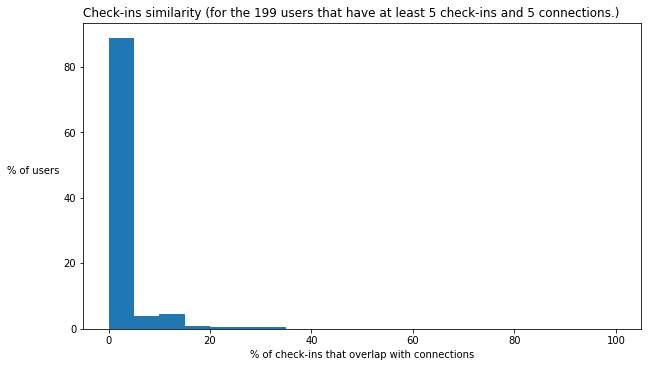

In [41]:
sims = load_database('sims.pickle')

def make_sims_histogram(sims=sims):
    from numpy import histogram
    VISITS_THRESHOLD = 5
    CONNS_THRESHOLD = 5
    percent_in_common = [common/total*100 for num_conns, total, common in sims.values()
                         if total >= VISITS_THRESHOLD and num_conns >= CONNS_THRESHOLD]
    counts_in_common, bins_in_common = histogram(percent_in_common, bins=list(range(0, 105, 5)))
    print(list((c/len(percent_in_common)*100, b) for c, b in zip(counts_in_common, bins_in_common)))

    from matplotlib.pyplot import figure, hist, title, xlabel, ylabel
    figure(figsize=(10, 5.625))
    hist(bins_in_common[:-1], bins_in_common,
         weights=[c/len(percent_in_common)*100 for c in counts_in_common])
    title(f'Check-ins similarity (for the {len(percent_in_common):,} users that have at least {VISITS_THRESHOLD:,} check-ins and {CONNS_THRESHOLD:,} connections.)',
          loc='left')
    xlabel('% of check-ins that overlap with connections')
    ylabel('% of users', rotation=0, horizontalalignment='right')
    pass

make_sims_histogram()

# Part G: Recommending new connections #

The check-ins data allows us to do something interesting: we can try to suggest **new** connections based on similar visit behavior!

## Exercise 9 (**3** points): `suggest_friends` ##

Complete the function,
```python
def suggest_friends(user_id, visit_vectors, connection_vectors):
    ...
```
so that it **suggests new friends** for a given user. Here are the requirements:

**Inputs:**
- `user_id`: A user ID, given as an integer.
- `visit_vectors`: The collection of visit vectors for all users (see Part F, Exercise 7).
- `connection_vectors`: The collection of connection vectors for all users (see Part E, Exercise 6).

**Task:** Compare the visit vector for `user_id` against the visit vectors of all other users who have a visit vector but are **not** _already_ connected to that user. Return the top matches.

**Outputs:** Return the top 3 most similar candidates as a Python list of pairs. The first element of the pair is the suggested user ID and the second is the similarity measure. The output must be sorted in _descending_ order from most matches to fewest matches. Break ties using the user ID in _ascending_ order. If there are fewer than 3 matches, return them all.

**Notes:**
1. If user `user_id` does not have a visit vector, return an empty list.
2. The top "matches" (excluding existing connections) might have a similarity score of 0.

In [42]:
### Define demo inputs
demo_user_id_ex9 = 101

demo_visit_vectors_ex9 = \
{100: {'e3832a', '344274'},
 101: {'9ae1fe', 'e3832a', 'e5495e', '344274'},
 102: {'e5495e'},
 103: {'e5495e', 'e3832a', '9ae1fe', '344274'},
 105: {'344274'},
 106: {'e5495e', 'e3832a', '9ae1fe'},
 107: {'e3832a'}}

demo_connection_vectors_ex9 = { \
  100: {101, 102, 103},
  101: {104, 100, 103},
  103: {101},
  104: {107, 100, 101, 103},
  105: {100},
  106: {107, 103}}

<!-- Expected demo output text block -->
A correct implementation should produce the following result on the demo inputs above:
```
[(106, 3), (102, 1), (105, 1)]
```
<!-- Include any shout outs here -->

In [43]:
### Exercise 9 solution
def suggest_friends(user_id, visit_vectors, connection_vectors):
    ###
    EMPTY_SET = set()
    TOP = 3
    if user_id not in visit_vectors:
        return []
    user_visits = visit_vectors[user_id]
    user_conns = connection_vectors.get(user_id, EMPTY_SET)
    non_conns = set(visit_vectors.keys()) - {user_id} - user_conns
    candidates = [(candidate, len(user_visits & visit_vectors.get(candidate, EMPTY_SET)))
                  for candidate in non_conns]
    ordered_candidates = sorted(candidates, key=lambda c: (c[1], -c[0]), reverse=True)[:TOP]
    return ordered_candidates
    ###
    
### demo function call
pprint(suggest_friends(demo_user_id_ex9, demo_visit_vectors_ex9, demo_connection_vectors_ex9))

[(106, 3), (102, 1), (105, 1)]


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 9. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [44]:
### test_cell_ex9
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_9', 
    'func': suggest_friends, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'user_id':{
            'dtype':'int', # data type of param.
            'check_modified':True,
        },
        'visit_vectors':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
        'connection_vectors':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'list',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


# Fin: Submit your work! #

If you have made it this far, congratulations on completing the exam. **Don't forget to submit!**

If you are interested in exploring this topic after the exam is over, run the friend suggester on other users and see how the distribution of candidate matches compares to existing matches. Is there an improvement? Can you come up with a better method?